In [25]:
# definitely used
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from tree_learn.util import get_eval_res_components, get_segmentation_metrics, plot_instance_evaluation_segments

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# paths
benchmark_forest_path = '' # path to benchmark forest
eval_results_base_dir = '' # base directory of eval results (contains instance_evaluation.pt)

# utils

In [35]:
FLOOR_NUM_IN_INSTANCE_LABELS = 9999
FLOOR_NUM_IN_INSTANCE_PREDS = -1


def load_results(base_dir, benchmark_forest_path=benchmark_forest_path):
    instance_evaluation_path = os.path.join(base_dir, 'instance_evaluation.pt')
    instance_evaluation = torch.load(instance_evaluation_path)

    benchmark_forest = np.load(benchmark_forest_path)
    instance_labels = benchmark_forest[:, 3]
    instance_preds = instance_evaluation['instance_preds_propagated_to_benchmark_pointcloud']

    return instance_evaluation, instance_labels, instance_preds


def get_qualitative_assessment(instance_evaluation, verbose=True):
    if verbose:
        print(f"Number of matched predictions: {len(instance_evaluation['detection_results']['matched_preds'])}")
        print(f"non_matched_predictions: {instance_evaluation['detection_results']['non_matched_preds']}; non_matched_predictions corresponding gt: {instance_evaluation['detection_results']['non_matched_preds_corresponding_gt']}")
        print(f"non_matched_gt: {instance_evaluation['detection_results']['non_matched_gts']}; non_matched_gts_corresponding_larger_tree: {instance_evaluation['detection_results']['non_matched_gts_corresponding_larger_tree']}")
        print(f"non_matched_preds_where_corresponding_gt_is_nan: {instance_evaluation['detection_results']['non_matched_preds_where_corresponding_gt_is_nan']}")

    n_fp = len(instance_evaluation['detection_results']['non_matched_preds'])
    n_fn = len(instance_evaluation['detection_results']['non_matched_gts'])
    return n_fp, n_fn


def get_semantic_assessment(instance_labels, instance_preds, floor_num_in_instance_preds=FLOOR_NUM_IN_INSTANCE_PREDS, floor_num_in_instance_labels=FLOOR_NUM_IN_INSTANCE_LABELS):
    tree_preds = instance_preds != floor_num_in_instance_preds
    tree_labels = instance_labels != floor_num_in_instance_labels
    floor_preds = np.logical_not(tree_preds)
    floor_labels = np.logical_not(tree_labels)

    tp_tree, fp_tree, tn_tree, fn_tree = get_eval_res_components(tree_preds, tree_labels)
    tp_floor, fp_floor, tn_floor, fn_floor = get_eval_res_components(floor_preds, floor_labels)

    acc_tree, prec_tree, rec_tree, f1_tree, fdr_tree, fnr_tree, one_minus_f1_tree, iou_tree, fp_error_rate_tree, fn_error_rate_tree, error_rate_tree = get_segmentation_metrics(tp_tree, fp_tree, tn_tree, fn_tree)
    acc_floor, prec_floor, rec_floor, f1_floor, fdr_floor, fnr_floor, one_minus_f1_floor, iou_floor, fp_error_rate_floor, fn_error_rate_floor, error_rate_floor = get_segmentation_metrics(tp_floor, fp_floor, tn_floor, fn_floor)
    # if you want, you can also return measures for floor and trees separately
    
    print(f'accuracy: {acc_tree}')


def get_instance_assessment(instance_evaluation, n_instances_to_validate=156):
    assert (len(instance_evaluation['segmentation_results']['no_partition']) + len(instance_evaluation['detection_results']['non_matched_gts']) * 2) == n_instances_to_validate
    print(instance_evaluation['segmentation_results']['no_partition'][['prec', 'rec', 'f1', 'iou', 'fp_error_rate', 'fn_error_rate', 'error_rate']].mean(0))

# loading data

In [36]:
instance_evaluation, instance_labels, instance_preds = load_results(eval_results_base_dir)


# qualitative assessment of detections

In [37]:
n_fp, n_fn = get_qualitative_assessment(instance_evaluation)

Number of matched predictions: 156
non_matched_predictions: []; non_matched_predictions corresponding gt: []
non_matched_gt: []; non_matched_gts_corresponding_larger_tree: []
non_matched_preds_where_corresponding_gt_is_nan: []


# semantic segmentation

In [38]:
get_semantic_assessment(instance_labels, instance_preds)

accuracy: 0.9993098592944553


# instance segmentation

In [39]:
get_instance_assessment(instance_evaluation)

prec             0.982551
rec              0.987884
f1               0.984726
iou              0.970905
fp_error_rate    0.017221
fn_error_rate    0.011874
error_rate       0.029095
dtype: float64


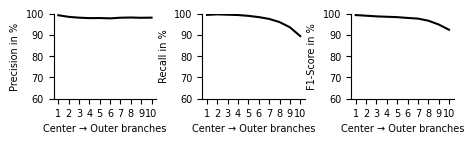

In [40]:
color = '#010003'
fontsize=7
fig_size=(4,1)
y_range=[60, 100]
x_label = "Center \u2192 Outer branches"
fig, axs = plt.subplots(1, 3, figsize=fig_size)
plt.tight_layout()


# precision
values = instance_evaluation['segmentation_results']['xy_partition_relative'].iloc[:, 2:12].mean(0).to_numpy() * 100
axs[0] = plot_instance_evaluation_segments(axs[0], values, fontsize=fontsize, measure="Precision in %", y_range=y_range, color=color, x_label=x_label)

# recall
values = instance_evaluation['segmentation_results']['xy_partition_relative'].iloc[:, 12:22].mean(0).to_numpy() * 100
axs[1] = plot_instance_evaluation_segments(axs[1], values, fontsize=fontsize, measure="Recall in %", y_range=y_range, color=color, x_label=x_label)


# f1-score
values = instance_evaluation['segmentation_results']['xy_partition_relative'].iloc[:, 22:32].mean(0).to_numpy() * 100
axs[2] = plot_instance_evaluation_segments(axs[2], values, fontsize=fontsize, measure="F1-Score in %", y_range=y_range, color=color, x_label=x_label)

fig.subplots_adjust(wspace=0.45, left=0, right=1, bottom=0.15, top=1)
plt.show()

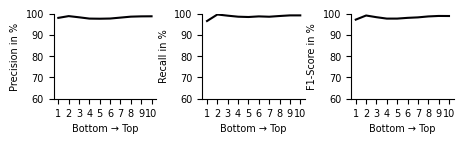

In [41]:
color = '#010003'
fontsize=7
fig_size=(4,1)
y_range=[60, 100]
x_label = "Bottom \u2192 Top"
fig, axs = plt.subplots(1, 3, figsize=fig_size)
plt.tight_layout()


# precision
values = instance_evaluation['segmentation_results']['z_partition_relative'].iloc[:, 2:12].mean(0).to_numpy() * 100
axs[0] = plot_instance_evaluation_segments(axs[0], values, fontsize=fontsize, measure="Precision in %", y_range=y_range, color=color, x_label=x_label)

# recall
values = instance_evaluation['segmentation_results']['z_partition_relative'].iloc[:, 12:22].mean(0).to_numpy() * 100
axs[1] = plot_instance_evaluation_segments(axs[1], values, fontsize=fontsize, measure="Recall in %", y_range=y_range, color=color, x_label=x_label)


# f1-score
values = instance_evaluation['segmentation_results']['z_partition_relative'].iloc[:, 22:32].mean(0).to_numpy() * 100
axs[2] = plot_instance_evaluation_segments(axs[2], values, fontsize=fontsize, measure="F1-Score in %", y_range=y_range, color=color, x_label=x_label)

fig.subplots_adjust(wspace=0.45, left=0, right=1, bottom=0.15, top=1)
plt.show()

# scrap

In [22]:
test = np.load('/usr/users/henrich1/datasets_simlink/data_trees/to_delete/test_ft_eval/pred_forest.npy')

In [15]:
tree0 = test[test[:, 3] == 0]

In [16]:
from tree_learn.util import explore_plotly

In [17]:
explore_plotly(tree0)